<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/02_classification_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: basic text classification**

| | |
|------|------|
| Filename | 02_classification_test.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | September 4, 2024 |
| Aim(s) | Build, train and evaluate a neural network machine learning model that classifies movie reviews as positives or negatives. |
| Dataset(s) | Stanford dataset [[1]](https://ai.stanford.edu/~amaas/data/sentiment/)|
| Version | Python 3.12 - TensorFlow 2.17.0 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. CPU execution is enough.
3. Run all and read comments.

---

#### **Motivation**

The Stanford Sentiment Treebank database - composed of over 50,000 movie reviews on internet - is used to built a binary classification model. In the last section, weights of the neural network are used to make correspondences and analogies between words.

---



#### **0. Input section**

The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [35]:
training_phase = 'No'

---


#### **1. Python librairies & display utilities [RUN ME]**

In [36]:
from os import path, listdir                                                    # miscellaneous operating system interfaces
from re import escape                                                           # regular expressions
from shutil import rmtree                                                       # operations on files
from string import punctuation                                                  # string manipulation
from numpy import shape, linalg, cos, sin, pi, argmax, max                      # scientific computing
from tensorflow import constant, keras, strings, expand_dims, data, metrics     # machine learning models
from PIL import Image                                                           # image processing capabilities
import matplotlib.pyplot as plt                                                 # graphing package

In [37]:
# get the pre-trained model and training curves from the Github repertory TensorFlow
# called when training_phase = "No" in section 0

def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # clone TensorFlow repertory
  training_curves = Image.open("TensorFlow_duplicata/99_pre_trained_models/02_classification_text/results_graph.jpeg") # see section 2.4
  model = keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/02_classification_text/02_classification_text.keras', custom_objects={'custom_standardization': custom_standardization}) # pre-trained model
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return training_curves, model


In [38]:
# show a random movie review with its label associated

def plot_text(text_batch):
  for text_batch, label_batch in text_batch:
      if label_batch.numpy()[0] == 0:
        print("Here's an extract from a negative review:")
        print(text_batch.numpy()[0])
      else:
        print("Here's an extract from a positive review:")
        print(text_batch.numpy()[0])


In [39]:
# plot training curves for the training and validation set

def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  fig = plt.subplot(2,1,1)
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6), plt.ylabel('Loss', fontsize=12)

  plt.subplot(2,1,2)
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.xlabel('Epochs', fontsize=12), plt.ylabel('Accuracy', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)

---


#### **2. Data retrieval and set generation**

###### **2.1. Stanford Sentiment Treebank Dataset**

Stanford Sentiment Treebank (SST) is a database created for sentiment analysis in movie reviews. It contains movie reviews labeled with sentiment (positive or negative).


In [40]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = keras.utils.get_file("aclImdb_v1", url, extract=True, cache_dir='.', cache_subdir='')
dataset_dir = path.join(path.dirname(dataset), 'aclImdb')

The extracted file `aclImdb` is composed of 5 folders:

*   `train`
    * `pos`: contains movie reviews with a positive sentiment (rating > 7/10)
    * `neg`: with a negative sentiment (rating < 4/10)
    * `unsup`: for unsupervised learning
*   `test`: contains movie reviews meant for testing
    * `pos`
    * `neg`
*   `README`: provides information about the dataset and how to use it
*   `imdb.vocab` and `imdbEr.txt` contain additional information about errors, URL website and specific annotations


In [41]:
listdir(dataset_dir) # check the file names in the aclImdb directory

['imdb.vocab', 'imdbEr.txt', 'test', 'train', 'README']

In [42]:
train_dir = path.join(dataset_dir, 'train') # path name of the "train" file in dataset_dir
remove_dir = path.join(train_dir, 'unsup') # remove the folder with unlabeled reviews for unsupervised learning
rmtree(remove_dir)

###### **2.2. Training and validation datasets**

Movie reviews are divided into 3 splits: `train`, `test` and `validation`. Only the validation set is not available into `aclImdb` and so it is created by using 20% of the training dataset.

These datasets are randomly shuffled ad then batches with the API utils. Datasets are stored in the data structures `tf.data.Dataset`. The advantage is that batches are not loaded into the immediate memory but only when they are called up.

In [43]:
batch_size = 32
raw_train_ds = keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='training', shuffle=True, seed=42) # 625 batches of 32 texts for training set randomly chosen
raw_val_ds = keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='validation', shuffle=True, seed=42) # 157 batches of 32 texts for validation set randomly chosen
raw_test_ds = keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size) # 782 batches of 32 texts for test set

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [44]:
plot_text(raw_train_ds.take(1)) # show an example of movie review from the first training set batch

Here's an extract from a negative review:
b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'


---


#### **3. Pre-processing & reformating data**

###### **3.1. Pre-processing layer**

The textual data is pre-processed and converted before being used by the model. Three crucial phases are established:
- standardization
- tokenization
- vectorization

The standardization step replaces upper case with lower case letters and removes html tags/punctuation characters.

In [45]:
punctuation = escape(punctuation)
print("The punctuation characters eliminated are: \n", " \n", punctuation)

The punctuation characters eliminated are: 
  
 !"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~


In [46]:
@keras.utils.register_keras_serializable()
def custom_standardization(input_text):
  no_uppercases = strings.lower(input_text) # upper cases --> lower cases
  no_html_uppercases = strings.regex_replace(no_uppercases, '<br />', ' ') # remove HTML strings
  no_punctuation_html_uppercases = strings.regex_replace(no_html_uppercases, '[%s]' % punctuation, '') # remove punctuation
  return no_punctuation_html_uppercases

The tokenization phase transformes words and strings into tokens. Finally, tokens are converted into integers at the vectorization phase. A dictionary of the 5,000 most frequently used words is created in order to match a token with the associated word [[2]](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). The other little-used words - like actor names or non-evocative words - are not kept

In [47]:
max_features = 5000 # size of the dictionary
max_length = 500 # maximum number of words per review

vectorize_layer = keras.layers.TextVectorization(standardize=custom_standardization,
                                                 max_tokens=max_features,
                                                 output_sequence_length=max_length,
                                                 output_mode='int')

vectorize_layer.adapt(raw_train_ds.map(lambda x, y: x)) # dictionary creation with raw training texts (no label)

###### **3.2. Transformation visualization**

In [48]:
# get the integer tensor of a text after pre-processing

def token_to_int(raw_text):
  raw_text = next(iter(raw_text))[0]
  print("Review before tokenization and vectorization: \n", raw_text[0])
  print(" ")
  text_vectorized = expand_dims(raw_text, -1) #
  text_vectorized = vectorize_layer(text_vectorized)
  print("Review after tokenization and vectorization: \n", text_vectorized[0])

In [49]:
token_to_int(raw_train_ds)

Review before tokenization and vectorization: 
 tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer S

In [50]:
# get the word for a specific dictionary integer

def int_to_token(index):
  token = vectorize_layer.get_vocabulary()[index]
  print("The integer %d represents the token: %s" %(index, token))

In [51]:
int_to_token(7)

The integer 7 represents the token: is


---


#### **4. Model and training**


###### **4.1. Dataset performances**

*   `prefetch`: prefetch next batch while training. Avoid the risk of bottleneck (GPU Vs. I/O). The prefetch buffer size is automatically set via AUTOTUNE.
*   `cache`: dataset fits in RAM.

In [52]:
AUTOTUNE = data.AUTOTUNE # prefetch buffer size parameter

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

###### **4.2. Neural network architecture & compilation**

* Pre-processing layer `vectorize_layer`:
  * **Inputs:** strings of dimension `batch_size`
  * **Outputs:** an integer 2D tensor (`batch_size`, `max_length`)
  * **Comments:** if the number of string is less than `max_length`, the tensor is padded with zeros

* Embedding layer `Embedding`:
  * **Outputs:** a float 3D tensor (`batch_size`, `max_length`, `embedding_dim`)
  * **Comments:** each token is expressed as a float vector of dimension `embedding_dim`. All these vectors forme a dictionary which is modified/adapted during the learning phase. Components of an embedding vector are considered as weights

* Pooling layer `GlobalAveragePooling1D`:
  * **Outputs:** a float 2D tensor (`batch_size`, `embedding_dim`)
  * **Comments:** average value of vector components

* Fully-connected layer `Dense`:
  * **Outputs:** a scalar  0 (=negative sentiment) and 1 (=positive sentiment).
  * **Comments:** close to 0 = negative sentiment, close to 1 = positive sentiment, close to 0.5 = no clear opinion

In [53]:
def create_model():
  embedding_dim = 16
  model = keras.Sequential([vectorize_layer, # pre-processing layer
                            keras.layers.Embedding(input_dim = max_features, output_dim = embedding_dim),
                            keras.layers.Dropout(0.2),
                            keras.layers.GlobalAveragePooling1D(),
                            keras.layers.Dropout(0.2),
                            keras.layers.Dense(1, activation='sigmoid')
                            ], name="Sequential_1")

  model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=[metrics.BinaryAccuracy()])

  return model

###### **4.3. Training phase**


In [54]:
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, callbacks=[stop_early, cp_callback], **kwargs)

  return log.history["loss"], log.history["binary_accuracy"], log.history["val_loss"], log.history["val_binary_accuracy"]

In [55]:
epochs = 100

if training_phase == "Yes":
  model = create_model()
  stop_early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True, min_delta=0.001)

  cp_callback = keras.callbacks.ModelCheckpoint(filepath='02_classification_text.keras',
                                          monitor = "val_binary_accuracy",
                                          save_best_only = True,
                                          mode = "max",
                                          save_weights_only=False,
                                          verbose=0)

  classifier_accuracy = train_model(model, raw_train_ds, raw_val_ds, epochs=epochs)
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), argmax(classifier_accuracy[3])+1))

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 339 (delta 127), reused 88 (delta 88), pack-reused 194 (from 2)
Receiving objects: 100% (339/339), 31.32 MiB | 28.38 MiB/s, done.
Resolving deltas: 100% (167/167), done.


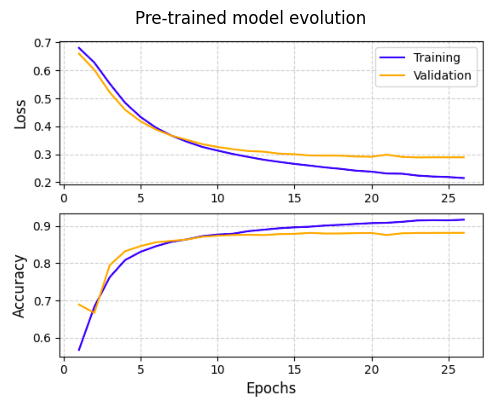

In [56]:
if training_phase == 'Yes':
  plot_evolution(classifier_accuracy)
else:
  training_curves, model = get_github_files() # retrieve the pre-trained model and training curves
  plt.imshow(training_curves), plt.title("Pre-trained model evolution"), plt.axis("off")

---


#### **4. Evaluation and predictions**


In [57]:
loss_test, accuracy_test = model.evaluate(raw_test_ds, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(loss_test, 100*accuracy_test))

Test loss function value 0.3 and test accuracy value 88.5 %


The model can be used to recognize the sentiment of new/fictitious movie review.

In [58]:
my_review = ["This movie was terrible and boring. Most of scenes were violents and useless."]

In [59]:
examples = constant(my_review)

prediction = model.predict(examples)
if prediction < 0.5:
  print("The movie looks pretty bad. (score model: ", round(prediction[0][0], 1), ")")
else:
  print("Great movie, go see it in the cinema! (score model: ", round(prediction[0][0], 1), ")")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
The movie looks pretty bad. (score model:  0.1 )


---


#### **5. Go further: the embedding dictionary**

In [60]:
embeddings_vector = model.layers[1].get_weights()[0] # get the 5,000 vectors of the embedding layer
print("The dictionary size is equal to:",(shape(embeddings_vector)))
dictionary_embedding = {vectorize_layer.get_vocabulary()[i]:embeddings_vector[i] for i in range(max_features)} # built the embedding dictionary

The dictionary size is equal to: (5000, 16)


The embedding dictionary can be visualized as a 16-dimensional space where each of the 5,000 words is an element of this space. For example, the word "good" corresponds to:

In [61]:
dictionary_embedding["good"]

array([-0.7068291 , -0.8950667 ,  0.7667451 ,  0.6835332 , -0.85558134,
        0.8109165 , -0.94413424,  0.784986  ,  0.86634517,  0.66729796,
       -0.71538705,  0.81901556,  0.92852104, -0.7565169 , -0.7710601 ,
        0.76415795], dtype=float32)

A notion of distance can be introduced in the embedding space
[[3]](https://www.cs.toronto.edu/~lczhang/360/lec/w05/w2v.html) and therefore, two words are "close" to each other in the embedding space if the distance between them is low.

In [62]:
# get the distance between two elements in the embedding space

def get_distance(token1, token2):
  p1 = dictionary_embedding[token1]
  p2 = dictionary_embedding[token2]
  distance = linalg.norm(p2-p1)
  return distance

In [63]:
get_distance("good", "terrible")

18.659864

In [64]:
get_distance("disappointing", "terrible")

1.940095

With the notion of distance, it's possible to explore the entire embedding dictionary to find the words closest to a specific word.

In [65]:
# get elements closest to a specific element in the embedding space

def get_synomym(token, n):
  p1 = dictionary_embedding[token]
  candidate_list = {} # stores n synonyms
  for i in range(1, 1000):
    token_candidate = vectorize_layer.get_vocabulary()[i]
    candidate_list[token_candidate] = get_distance(token, token_candidate)

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])

  synonym_list = sorted_items[1:n+1]
  words = [(item[0], item[1]) for item in synonym_list]
  return print(words)

In [66]:
word = "terrible"
nb = 10
get_synomym(word, nb)

[('avoid', 0.44538143), ('poor', 0.46396747), ('mess', 0.47647947), ('dull', 0.53160685), ('worse', 0.5948652), ('annoying', 0.9648157), ('horrible', 1.1609063), ('lame', 1.5456003), ('bad', 1.767801), ('fails', 1.7728525)]


In [67]:
def get_analogy(vector, n):
  candidate_list = {} # stores n synonyms
  for i in range(1, 5000):
    token_candidate = vectorize_layer.get_vocabulary()[i]
    vector_candidate = dictionary_embedding[token_candidate]
    candidate_list[token_candidate] = sum(abs(vector - vector_candidate))

  sorted_items = sorted(candidate_list.items(), key=lambda item: item[1])
  synonym_list = sorted_items[0:n]
  words = [item[0] for item in synonym_list]
  print(words)

In [68]:
analogy = dictionary_embedding["funny"] - dictionary_embedding["nice"] + dictionary_embedding["terrible"]
get_analogy(analogy, 5)

['awful', 'poorly', 'boring', '410', 'worse']
